In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

c:\Users\sugay\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

データの読み込み

GPUで作ったPickleのファイルは，CPUではそのままでは使えないため，工夫が必要．

https://www.kunita-gamefactory.com/post/%E3%80%90pytorch%E3%80%91gpu%E3%81%A7%E8%A8%93%E7%B7%B4%E3%81%95%E3%81%9B%E3%81%9F%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92cpu%E3%81%A7%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%82%E3%81%86%E3%81%A8%E3%81%97%E3%81%9F%E3%81%8A%E8%A9%B1

を真似したらうまくCPU上でもファイルを読み込むことができるようになった．

In [3]:
import io
        
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [4]:
# ファイルの相対パスを指定
file_path = 'data_storage/Ising_samp_data_L16_beta.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file, encoding='latin1')
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, beta_data = loaded_data

In [5]:
# データの形を確認
spin_data.shape , len(beta_data)

(torch.Size([25000, 16, 16]), 25000)

In [6]:
spin_data = spin_data.unsqueeze(1)
spin_data.shape

torch.Size([25000, 1, 16, 16])

In [7]:
j = 24999
print(spin_data[j], beta_data[j])

tensor([[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
          -

In [8]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, beta_train, beta_test = train_test_split(spin_data, beta_data, test_size=0.5)

In [9]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
beta_train = torch.tensor(beta_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
beta_test = torch.tensor(beta_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

C:\Users\sugay\AppData\Local\Temp\ipykernel_5640\3092628271.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_5640\3092628271.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)


In [10]:
for j in range(200):
    print(beta_train[j])

tensor([0.6400])
tensor([0.4400])
tensor([0.9600])
tensor([0.2400])
tensor([0.4400])
tensor([0.2000])
tensor([0.5200])
tensor([0.2400])
tensor([0.2800])
tensor([0.8400])
tensor([0.4400])
tensor([0.1200])
tensor([0.3200])
tensor([0.4400])
tensor([0.3600])
tensor([0.6800])
tensor([0.8400])
tensor([0.4400])
tensor([0.3200])
tensor([0.0400])
tensor([0.4000])
tensor([0.8400])
tensor([0.9200])
tensor([0.9600])
tensor([0.4400])
tensor([0.0400])
tensor([0.4000])
tensor([0.2000])
tensor([0.3200])
tensor([0.2800])
tensor([0.1200])
tensor([0.0800])
tensor([0.6400])
tensor([0.4000])
tensor([0.0400])
tensor([0.8400])
tensor([0.1600])
tensor([0.9200])
tensor([0.8400])
tensor([0.1600])
tensor([0.4000])
tensor([0.1200])
tensor([0.4000])
tensor([0.3600])
tensor([0.3200])
tensor([0.7200])
tensor([0.0800])
tensor([0.7200])
tensor([0.4400])
tensor([0.3200])
tensor([0.3600])
tensor([0.1600])
tensor([0.8400])
tensor([0.4800])
tensor([0.6400])
tensor([0.8800])
tensor([0.7200])
tensor([0.8400])
tensor([0.5200

In [11]:
beta_train[1]

tensor([0.4400])

正解データはone-hot表現にする必要がある

In [12]:
# テンソルを新しいテンソルに変換する関数を定義
def to_one_hot(data, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int((val-0.01) / 0.04)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# temp_train,temp_testをone-hotベクトルに変換
one_hot_beta_train = to_one_hot(beta_train, num_classes=25)
one_hot_beta_test = to_one_hot(beta_test, num_classes=25)

In [13]:
for j in range(100):
    print(one_hot_beta_train[j])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 

In [14]:
beta_train[99]

tensor([0.6400])

In [15]:
beta_train[6]

tensor([0.5200])

In [16]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_beta_train)
test_dataset = TensorDataset(spin_test, one_hot_beta_test)

In [17]:
train_dataset[1]

(tensor([[[-1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,
           -1., -1.],
          [-1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
           -1., -1.],
          [-1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
           -1., -1.],
          [ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [18]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [19]:
transformed_train_dataset[12499]

(tensor([[[ 1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
           -1.,  1.],
          [ 1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,
            1.,  1.],
          [ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,
           -1., -1.],
          [ 1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
            1., -1.],
          [ 1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,
           -1., -1.],
          [-1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,
           -1.,  1.],
          [ 1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
           -1.,  1.],
          [ 1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
           -1., -1.],
          [ 1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,
           -1., -1.],
          [ 1.,  1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1

In [20]:
# DataLoaderの設定（バッチサイズ125）
train_loader = DataLoader(transformed_train_dataset, batch_size=15, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=15)

In [21]:
data_iter = iter(train_loader)
imgs, labels = next(data_iter)
labels

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [22]:
imgs.size(), labels.size()

(torch.Size([15, 1, 16, 16]), torch.Size([15, 25]))

In [23]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([15, 1, 16, 16]), torch.Size([15, 25]))

モデルを定義

In [24]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, in_channels, out_channels):
        super().__init__()
        # 畳み込みの部分
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(0),  # 反射パディング
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=4, bias=True),
            nn.ReLU(inplace=True),
        )
        # 全結合の部分
        self.fc = nn.Sequential(
            nn.Linear(out_channels*4*4, output_size, bias=True),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

モデルのインスタンス化

In [25]:
input_size = 16*16
output_size = 25
in_channels = 1
out_channels = 5  
model = CNN(input_size, output_size, in_channels, out_channels)
model.to(device)
# モデルの概要表示
print(model)

CNN(
  (conv): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(1, 5, kernel_size=(4, 4), stride=(4, 4))
    (2): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=25, bias=True)
    (1): Softmax(dim=1)
  )
)


損失関数と最適化アルゴリズムの設定

In [26]:
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=5e-5)     # Adam,L2正則化

学習の実行

In [27]:
num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float().cpu()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) # 正解数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 3.190003906794303, acc: 0.08896888792514801, test loss: 3.1732106743384896, test acc: 0.12382069230079651
epoch: 1, loss: 3.1554983285405367, acc: 0.1391683667898178, test loss: 3.1573190994971663, test acc: 0.13413232564926147
epoch: 2, loss: 3.138555349491769, acc: 0.15635447204113007, test loss: 3.151028521912847, test acc: 0.13469192385673523
epoch: 3, loss: 3.128854167261284, acc: 0.16458797454833984, test loss: 3.146252533800596, test acc: 0.1370900422334671
epoch: 4, loss: 3.1194512298067125, acc: 0.17881648242473602, test loss: 3.1422472366040273, test acc: 0.14252562820911407
epoch: 5, loss: 3.1121258998660446, acc: 0.1868898570537567, test loss: 3.14123557654502, test acc: 0.13469207286834717
epoch: 6, loss: 3.106454520774402, acc: 0.19216562807559967, test loss: 3.14066354633807, test acc: 0.1422858089208603
epoch: 7, loss: 3.101349442982845, acc: 0.2000792771577835, test loss: 3.1390385293274474, test acc: 0.1466023325920105
epoch: 8, loss: 3.097501072380468

損失関数と正解率のグラフの作成

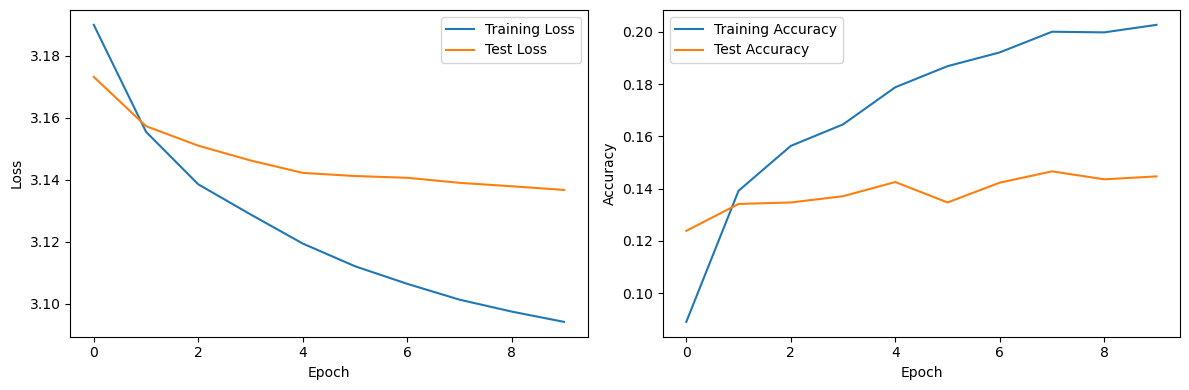

In [28]:
# グラフのプロット
plt.figure(figsize=(12, 4))

# 損失関数のグラフ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 正解率のグラフ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [29]:
print(test_pred[:124])

tensor([14,  0, 14,  0, 14])


In [30]:
print(test_targets[:100])

tensor([24,  4, 12,  0, 16])


In [31]:
test_output.shape

torch.Size([5, 25])

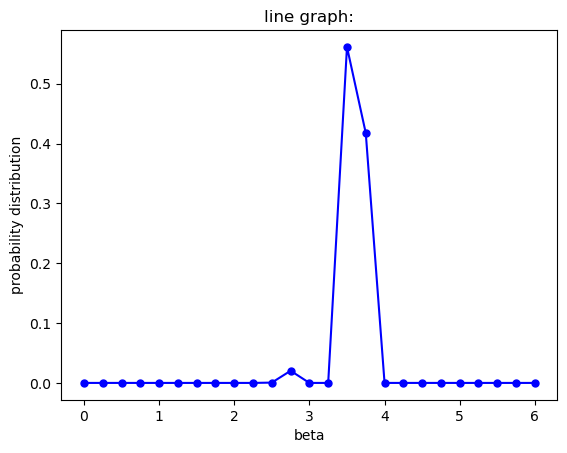

tensor(6.)


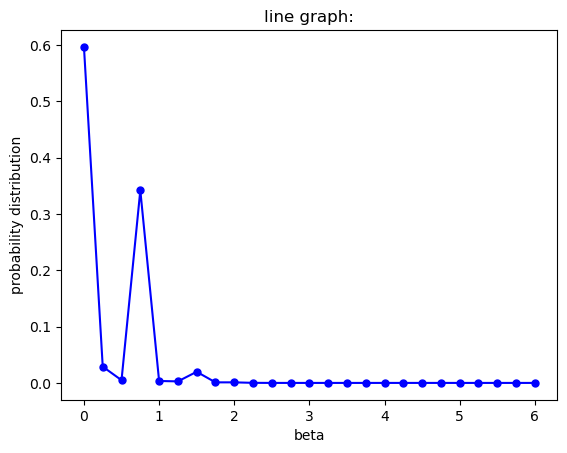

tensor(1.)


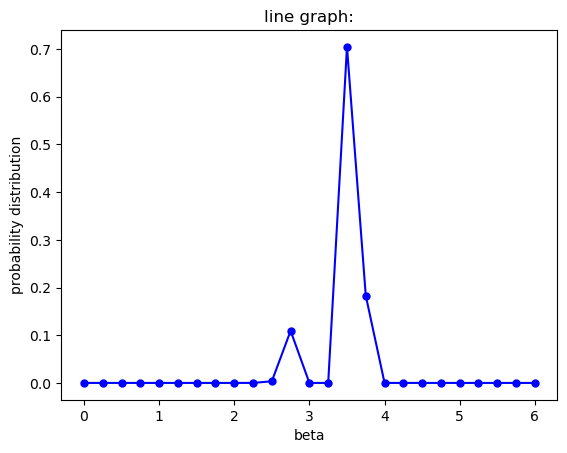

tensor(3.)


In [32]:
# データのx軸値
x = [i * 0.25 for i in range(25)]

for n in range(3):
    # テンソルをホストメモリにコピーしてNumpy配列に変換
    test_output_cpu = test_output[n].detach().cpu().numpy()

    # グラフを描画
    plt.plot(x, test_output_cpu, marker='o', linestyle='-', color='b', markersize=5)

    # グラフのタイトルと軸ラベルを設定
    plt.title('line graph:')
    plt.xlabel('beta')
    plt.ylabel('probability distribution')

    # グラフを表示
    plt.show()

    print(test_targets[n]*0.25)


モデルの保存

In [33]:
# # データを保存するディレクトリのパス
# save_dir = "data_storage"

# # ファイル名
# file_name = "CNN_L16_beta.prm"

# # フルパスを作成
# full_path = os.path.join(save_dir, file_name)

# # パラメータを保存
# # torch.save(file_name, full_path)

In [34]:
torch.save(model.state_dict(), 'data_storage/CNN_L16_beta.pth')